# Data Science Capstone - Battle of the Neighborhoods Final Report

<b>Name:</b> Tyler Halterman<br>
<b>Date:</b> 08/02/2020<br>

## Table of Contents

<ol>
<li><b>Introduction</b><ol>
    <li>Background</li>
    <li>The Problem</li>
    <li>Target Audience</li></ol><br>
    
    
<li><b>Data Section</b><ol>
    <li>Datasets</li>
    <li>How Data is Used</li></ol><br>
        
<li><b>Methodology</b><ol>
    <li>Libraries</li>
    <li>Importing Data</li>
    <li>Analysis</li></ol><br>
    
    
<li><b>Results</b></li>
<li><b>Discussion</b></li>
<li><b>Conclusion</b></li>
</ol>

## 1. Introduction

### A. Background

I decided to use this capstone to help a family wanting to relocate to one of the biggest cities in the US, Indianapolis. When moving across the country, one would 
want to know where the safest neighborhood is and what venues are near that location. Once the safest neighborhoods are presented, a family would want to choose 
which one of the neighborhoods would offer the most ammenities that are within a set budget. A big issue with moving is the real-estate prices that fluctuate according
to the condition of the surrounding neighborhood. As crime goes up, real estate prices drop; a common trend in real-estate. So, deciding where to live is a give and take
with picking a neighborhood that is safe to raise a family that has a plethora of ammenities all while staying within budget. This project seeks to provide an answer 
by breaking the city of indianapolis up by police beat, locating venues and finding the average housing price within said beat. 

### B. The Problem

For this project, let's provide an answer for families belonging to four socio-economic classes; ultra wealthy, upper class, middle class, lower class. 
I would break down the classes into economic brackets containing the following. Keep in mind that by "class" I am only referring to the economic bracket of money made per year.<br><br>
<ol><li>Ultra Wealthy ~ 300k and up</li>
    <li>Upper Class   ~ 150k to 300k</li>
    <li>Middle Class  ~ 40k  to 150k</li>
    <li>Lower Class   ~ 0k to 40k</li>
    </ol>

### C. Target Audience

The target audience/stakeholders in this project will involve anyone moving to Marion County, Indiana. However, the general methodology and principles found in this 
   project can be applied to any city in the USA. 

## 2. Data Section

### A. Datasets

I will be using datasets obtained from credible sources for the crime statistics, real-estate prices, and venue locations. <br><br>
The crime data and police beat maps will be obtained from Indianapolis's government site: http://data.indy.gov/datasets/impd-ucr-2018-data/data?orderBy=X_COORD&selectedAttribute=Y_COORD <br>
The real-estate prices will be obtained by using mean housing price data by Township found at Zillow, Bestplaces and Realtor: https://www.bestplaces.net/cost_of_living/city/indiana/franklin_township_(marion_cnty) <br>
The venue data will be obtained using FourSquare's Developer API: https://foursquare.com/developers/account/profile

### B. How Data is Used

Once I obtain, load in, and clean up the data I will begin by using the crime data to rank the beats by safest townships. I will then use the mean housing data to rank the townships
by most affordable to live. Finally I will use FourSquare's API to find venues within a reasonable radius of the beat/township center that can accomodate a family's needs. To help people find similar neighborhoods in the safests beats/townships we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use a cluster size of 5 for this project that will cluster the beats into 5 clusters. The reason to conduct a K- means clustering is to cluster neighborhoods with similar venues together so that people can shortlist the area of their interests based on the venues/amenities around each neighborhood.

## 3. Methodology

### A. Libraries

In [2]:
!pip install geopy
!pip install geocoder
!pip install folium

import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

     |████████████████████████████████| 102kB 8.5MB/s ta 0:00:011
All Required Libraries Imported!


### B. Importing Data

In [29]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_338bd7fa67494854b79c33e2e69d13e2 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='6rA7PSWyjODv3B3TI_gsXi63VWbtBYR_G-DfPf8lHiFY',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_338bd7fa67494854b79c33e2e69d13e2.get_object(Bucket='datasciencecapstone-donotdelete-pr-ldmqmsqnarbtoc',Key='IMPD_UCR_2018_Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.drop(['TIME','OBJECTID','UCR', 'DATE_','CASE','X_COORD','Y_COORD'],axis=1,inplace=True)
df_data_1.head()


,CRIME,ADDRESS,BEAT
0,CRIMINAL HOMICIDE,617 N LUETT AVE,SW15
1,CRIMINAL HOMICIDE,3610 SCHOFIELD AVE,ND20
2,CRIMINAL HOMICIDE,1700 N SOMERSET AVE,NW25
3,CRIMINAL HOMICIDE,6017 WINGEDFOOT CT,NW80
4,CRIMINAL HOMICIDE,3600 N MITTHOEFER RD,NE70


In [48]:

body = client_338bd7fa67494854b79c33e2e69d13e2.get_object(Bucket='datasciencecapstone-donotdelete-pr-ldmqmsqnarbtoc',Key='beatlist.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)
df_data_3.head()


,BEAT,Housing Cost
0,ND55,400000
1,ND16,225000
2,NW25,260000
3,SE15,185000
4,DT25,250000


### C. Analysis

#### Crimes per Beat

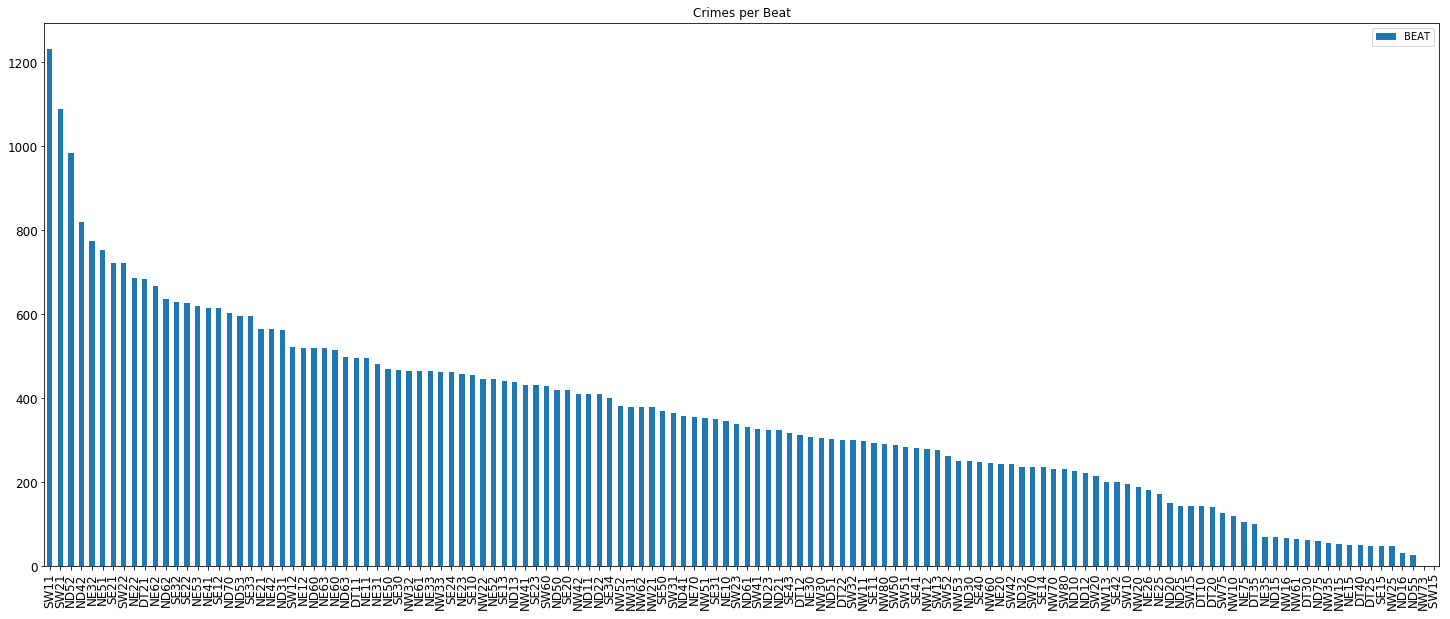

In [44]:
beatcrime = df_data_1['BEAT'].value_counts()
dfbeat = pd.DataFrame(beatcrime)
ax = dfbeat.plot(kind='bar', title ="Crimes per Beat", figsize=(25, 10), legend=True, fontsize=12)
plt.show()

#### Total Crimes per Category

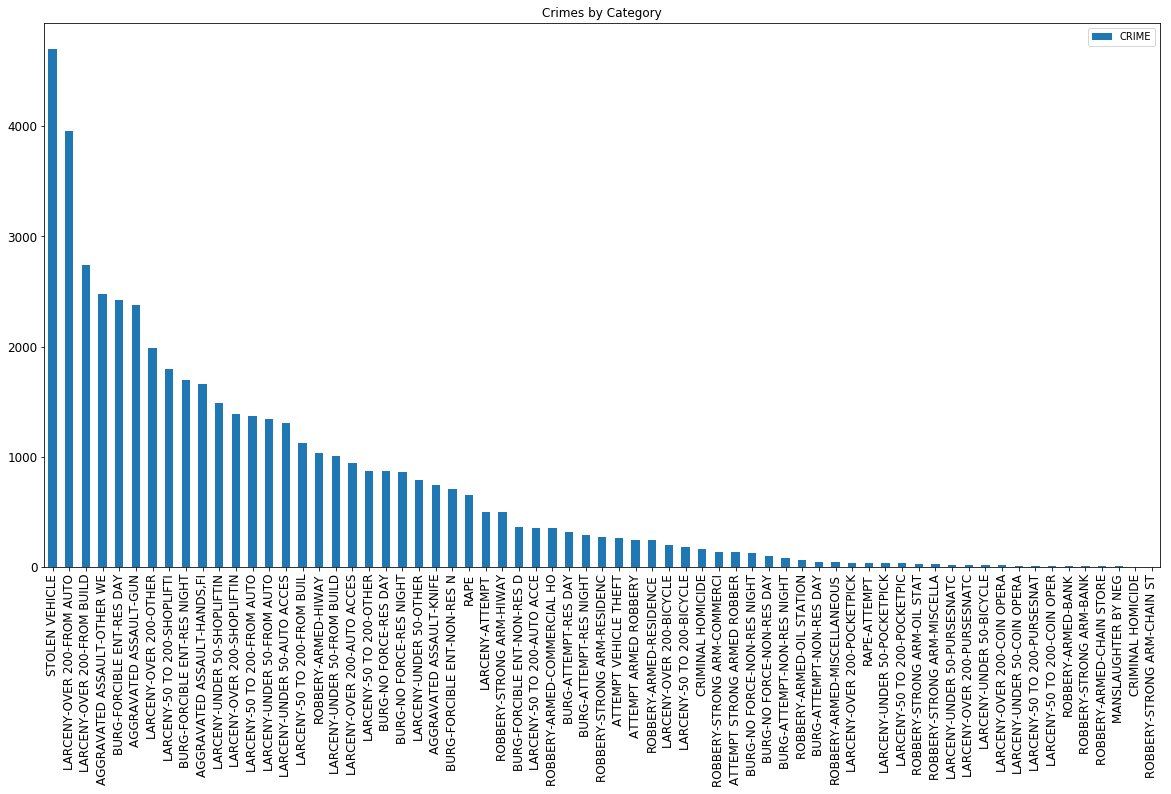

In [45]:
totalcrime = df_data_1['CRIME'].value_counts()
dfcrime = pd.DataFrame(totalcrime)
ax = dfcrime.plot(kind='bar', title ="Crimes by Category", figsize=(20, 10), legend=True, fontsize=12)
plt.show()

#### House Price by Beat

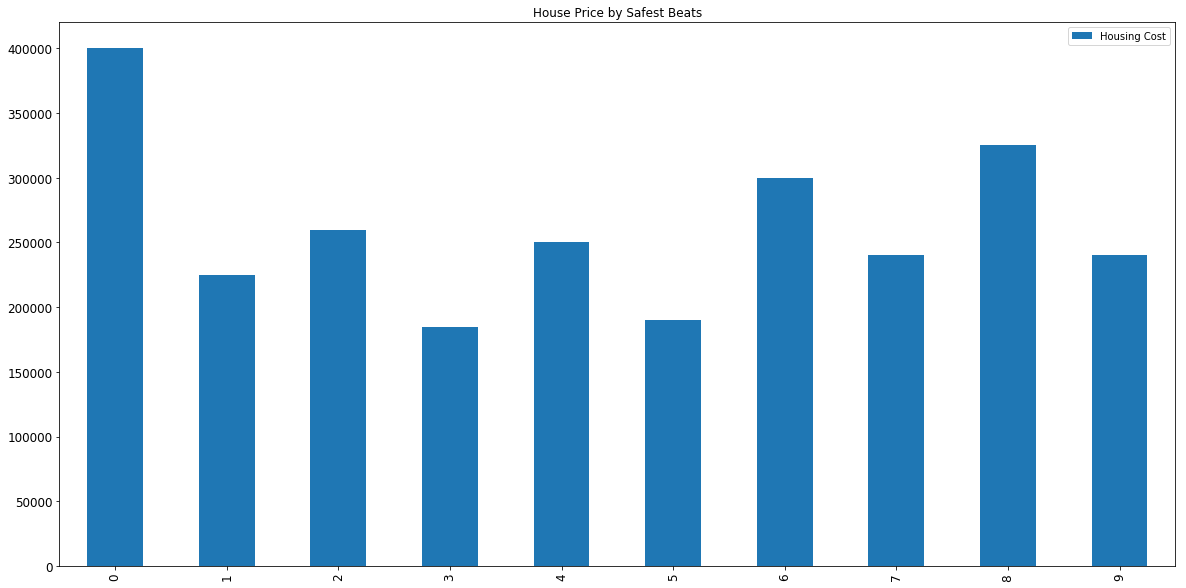

,BEAT,Housing Cost
0,ND55,400000
1,ND16,225000
2,NW25,260000
3,SE15,185000
4,DT25,250000
5,DT40,190000
6,NE15,300000
7,NW15,240000
8,NW35,325000
9,ND75,240000


In [57]:

ax = df_data_3.plot(kind='bar', title ="House Price by Safest Beats", figsize=(20, 10), legend=True, fontsize=12)
plt.show()
df_data_3

In [62]:
Beat = ['ND55','ND16','NW25','SE15','DT25','DT40',
'NE15','NW15','NW35','ND75']

City = ['Indianapolis','Indianapolis','Indianapolis','Indianapolis','Indianapolis','Indianapolis',
          'Indianapolis','Indianapolis','Indianapolis','Indianapolis']

Latitude = ['39.866344','39.839682','39.792641','39.755499','39.777005','39.758449','39.791516','39.806595','39.816851','39.895452']
Longitude = ['-86.135651','-86.135890','-86.206110','-86.134454','-86.147479','-86.149673','-86.119691','-86.213717','-86.254513','-86.166108']

df_neigh = {'BEAT': Beat,'City':City,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['BEAT', 'City', 'Latitude', 'Longitude'], index=None)

kut_neig

,BEAT,City,Latitude,Longitude
0,ND55,Indianapolis,39.866344,-86.135651
1,ND16,Indianapolis,39.839682,-86.135890
2,NW25,Indianapolis,39.792641,-86.206110
3,SE15,Indianapolis,39.755499,-86.134454
4,DT25,Indianapolis,39.777005,-86.147479
5,DT40,Indianapolis,39.758449,-86.149673
6,NE15,Indianapolis,39.791516,-86.119691
7,NW15,Indianapolis,39.806595,-86.213717
8,NW35,Indianapolis,39.816851,-86.254513
9,ND75,Indianapolis,39.895452,-86.166108


In [70]:
latitude = '39.766576' 
longitude = '-86.159541'
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, City, Beat in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['City'], kut_neig['BEAT']):
    label = '{}, {}'.format(Beat, City)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

In [86]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            'SIK1ZRGRSQEA2KWZZOTPXGUYC0BUC5ZJFK2FO5VUCHNWX1BO', 
            'X0SRB0IG14K2YR1IY1OJCCYCSGNBVJ12ACPBTEB2NIXBTIQV', 
            '20180604', 
            lat, 
            lng, 
           '500', 
            '30')
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['BEAT', 
                  'BEAT Latitude', 
                  'BEAT Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [87]:
kut_venues = getNearbyVenues(names=kut_neig['BEAT'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )

ND55
ND16
NW25
SE15
DT25
DT40
NE15
NW15
NW35
ND75


In [88]:
print(kut_venues.shape)
kut_venues.head()

(120, 7)


,BEAT,BEAT Latitude,BEAT Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ND55,39.866344,-86.135651,Broad Ripple Farmers Market,39.867494,-86.137574,Farmers Market
1,ND55,39.866344,-86.135651,Cork And Cracker,39.867092,-86.130560,Wine Shop
2,ND55,39.866344,-86.135651,Broad Ripple Park Canine Companion Area,39.867093,-86.130572,Dog Run
3,ND55,39.866344,-86.135651,Broad Ripple Park,39.869103,-86.132169,Dog Run
4,ND55,39.866344,-86.135651,Big Red Liquors,39.868983,-86.140187,Liquor Store


In [90]:
kut_venues.groupby('BEAT').count()

,BEAT Latitude,BEAT Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
BEAT,,,,,,
DT25,30,30,30,30,30,30
DT40,24,24,24,24,24,24
ND16,6,6,6,6,6,6
ND55,19,19,19,19,19,19
ND75,3,3,3,3,3,3
NE15,5,5,5,5,5,5
NW15,13,13,13,13,13,13
NW25,4,4,4,4,4,4
NW35,4,4,4,4,4,4


In [85]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 81 uniques categories.


In [91]:
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['BEAT'] = kut_venues['BEAT'] 

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,BEAT,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Beer Garden,Breakfast Spot,Brewery,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Discount Store,Distillery,Dive Bar,Dog Run,Electronics Store,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,German Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hospital,Hotel,Ice Cream Shop,Intersection,Irish Pub,Juice Bar,Liquor Store,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Moving Target,Music Store,Music Venue,New American Restaurant,Other Repair Shop,Park,Pawn Shop,Pet Store,Pizza Place,Playground,Pool,Pub,Salon / Barbershop,Sandwich Place,Shoe Store,Soup Place,Spanish Restaurant,Sporting Goods Shop,Sushi Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Trail,Volleyball Court,Wine Shop,Women's Store,Yoga Studio
0,ND55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ND55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,ND55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ND55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ND55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [93]:
kut_grouped = kut_onehot.groupby('BEAT').mean().reset_index()
kut_grouped

,BEAT,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Beer Garden,Breakfast Spot,Brewery,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Discount Store,Distillery,Dive Bar,Dog Run,Electronics Store,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,German Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hospital,Hotel,Ice Cream Shop,Intersection,Irish Pub,Juice Bar,Liquor Store,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Moving Target,Music Store,Music Venue,New American Restaurant,Other Repair Shop,Park,Pawn Shop,Pet Store,Pizza Place,Playground,Pool,Pub,Salon / Barbershop,Sandwich Place,Shoe Store,Soup Place,Spanish Restaurant,Sporting Goods Shop,Sushi Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Trail,Volleyball Court,Wine Shop,Women's Store,Yoga Studio
0,DT25,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.00,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.066667,0.033333,0.033333,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.033333,0.033333,0.000000,0.033333,0.033333,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.0,0.033333,0.033333,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.033333,0.066667,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
1,DT40,0.041667,0.000000,0.041667,0.000000,0.000000,0.083333,0.125000,0.000000,0.00,0.000000,0.041667,0.041667,0.000000,0.000000,0.041667,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.041667,0.000000,0.000000,0.041667,0.0,0.000000,0.000000,0.000000,0.000000,0.041667,0.041667,0.000000,0.000000,0.000000,0.083333,0.000000,0.00,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.00,0.000000,0.000000,0.000000
2,ND16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.00,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.00,0.000000,0.000000,0.000000
3,ND55,0.000000,0.000000,0.000000,0.105263,0.052632,0.000000,0.000000,0.000000,0.00,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.105263,0.000000,0.052632,0.000000,0.052632,0.0,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.052632,0.000000,0.000000,0.052632,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.00,0.052632,0.000000,0.000000
4,ND75,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [94]:
kut_grouped.shape

(10, 82)

In [95]:
num_top_venues = 5

for hood in kut_grouped['BEAT']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['BEAT'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----DT25----
         venue  freq
0          Bar  0.10
1      Theater  0.07
2  Coffee Shop  0.07
3      Gay Bar  0.03
4          Pub  0.03


----DT40----
                     venue  freq
0                      Bar  0.12
1                   Bakery  0.08
2  New American Restaurant  0.08
3              Coffee Shop  0.08
4      American Restaurant  0.04


----ND16----
               venue  freq
0                Gym  0.17
1         Playground  0.17
2  Other Repair Shop  0.17
3              Trail  0.17
4     Baseball Field  0.17


----ND55----
                venue  freq
0             Dog Run  0.11
1  Athletics & Sports  0.11
2      Farmers Market  0.05
3           Pet Store  0.05
4         Flower Shop  0.05


----ND75----
                       venue  freq
0                Yoga Studio  0.33
1                      Hotel  0.33
2                        Gym  0.33
3  Middle Eastern Restaurant  0.00
4                  Pawn Shop  0.00


----NE15----
            venue  freq
0            Food   0.2


In [96]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [97]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['BEAT']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['BEAT'] = kut_grouped['BEAT']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,BEAT,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,DT25,Bar,Coffee Shop,Theater,Comedy Club,Cupcake Shop,Deli / Bodega,Mexican Restaurant,Men's Store,Juice Bar,American Restaurant
1,DT40,Bar,New American Restaurant,Bakery,Coffee Shop,American Restaurant,Brewery,Distillery,Dive Bar,Ice Cream Shop,Pizza Place
2,ND16,Garden,Gym,Trail,Playground,Baseball Field,Other Repair Shop,Electronics Store,Deli / Bodega,Dessert Shop,Discount Store
3,ND55,Dog Run,Athletics & Sports,Beer Garden,Pet Store,Pool,Farmers Market,Sandwich Place,Moving Target,Gym / Fitness Center,Liquor Store
4,ND75,Yoga Studio,Gym,Hotel,Fast Food Restaurant,Dessert Shop,Discount Store,Distillery,Dive Bar,Dog Run,Electronics Store


In [98]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('BEAT', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 3, 0, 2, 4, 1, 2], dtype=int32)

In [99]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('BEAT'), on='BEAT')

kut_merged.head() # check the last columns!

,BEAT,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ND55,Indianapolis,39.866344,-86.135651,2,Dog Run,Athletics & Sports,Beer Garden,Pet Store,Pool,Farmers Market,Sandwich Place,Moving Target,Gym / Fitness Center,Liquor Store
1,ND16,Indianapolis,39.839682,-86.135890,2,Garden,Gym,Trail,Playground,Baseball Field,Other Repair Shop,Electronics Store,Deli / Bodega,Dessert Shop,Discount Store
2,NW25,Indianapolis,39.792641,-86.206110,4,Playground,Bar,Basketball Court,Park,Yoga Studio,Electronics Store,Deli / Bodega,Dessert Shop,Discount Store,Distillery
3,SE15,Indianapolis,39.755499,-86.134454,2,Fried Chicken Joint,Convenience Store,Flower Shop,Music Store,Mexican Restaurant,Brewery,Hotel,Bar,Music Venue,Thrift / Vintage Store
4,DT25,Indianapolis,39.777005,-86.147479,2,Bar,Coffee Shop,Theater,Comedy Club,Cupcake Shop,Deli / Bodega,Mexican Restaurant,Men's Store,Juice Bar,American Restaurant


In [100]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['BEAT'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

In [101]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,BEAT,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,NE15,Indianapolis,39.791516,-86.119691,0,Park,Discount Store,Moving Target,Food,Intersection,Electronics Store,Deli / Bodega,Dessert Shop,Distillery,Dive Bar


In [102]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,BEAT,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,NW35,Indianapolis,39.816851,-86.254513,1,Volleyball Court,Discount Store,Music Store,Cosmetics Shop,Yoga Studio,Electronics Store,Deli / Bodega,Dessert Shop,Distillery,Dive Bar


In [103]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,BEAT,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ND55,Indianapolis,39.866344,-86.135651,2,Dog Run,Athletics & Sports,Beer Garden,Pet Store,Pool,Farmers Market,Sandwich Place,Moving Target,Gym / Fitness Center,Liquor Store
1,ND16,Indianapolis,39.839682,-86.135890,2,Garden,Gym,Trail,Playground,Baseball Field,Other Repair Shop,Electronics Store,Deli / Bodega,Dessert Shop,Discount Store
3,SE15,Indianapolis,39.755499,-86.134454,2,Fried Chicken Joint,Convenience Store,Flower Shop,Music Store,Mexican Restaurant,Brewery,Hotel,Bar,Music Venue,Thrift / Vintage Store
4,DT25,Indianapolis,39.777005,-86.147479,2,Bar,Coffee Shop,Theater,Comedy Club,Cupcake Shop,Deli / Bodega,Mexican Restaurant,Men's Store,Juice Bar,American Restaurant
5,DT40,Indianapolis,39.758449,-86.149673,2,Bar,New American Restaurant,Bakery,Coffee Shop,American Restaurant,Brewery,Distillery,Dive Bar,Ice Cream Shop,Pizza Place
7,NW15,Indianapolis,39.806595,-86.213717,2,Grocery Store,Soup Place,Women's Store,Hospital,Fast Food Restaurant,Electronics Store,Discount Store,Cosmetics Shop,Chinese Restaurant,Salon / Barbershop


In [104]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,BEAT,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,ND75,Indianapolis,39.895452,-86.166108,3,Yoga Studio,Gym,Hotel,Fast Food Restaurant,Dessert Shop,Discount Store,Distillery,Dive Bar,Dog Run,Electronics Store


In [105]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,BEAT,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,NW25,Indianapolis,39.792641,-86.206110,4,Playground,Bar,Basketball Court,Park,Yoga Studio,Electronics Store,Deli / Bodega,Dessert Shop,Discount Store,Distillery


## 4. Results

The results of this report really show three things: What Beats are the safest?, What is the average cost of a home in said beat?, and what are the most popular venues in each beat clustered by 'similar neighborhoods?

## 5. Discussion

This analysis has derived the top ten safest beats in Indianapolis with the average home price in each beat. FourSquare API was used to find the venues surrounding each beat which then 
used the k-clustering machine learning algorithm to find which neighborhoods are similar according to available venues. 

## 6. Conclusion

Ultimately, I have concluded the following: <br><br>

If you want a wide array of venues to attend, you would want to live in cluster 2 which is for the most part located near downtown Indianapolis and Fishers/Carmel area. Additionally
, this cluster contains the widest array of housing prices which range from 180k --> 400k. As a second resort, cluster one contains a more shopper/consumer focus with more places 
to shop (This makes sense as this is close to Indianapolis Speedway). 